In [1]:
# Let's start implementing the step-by-step code to calculate the optimal portfolio under the given constraints.

import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Download data
end = dt.datetime.now()
start = end - dt.timedelta(days=365 * 5)
stocks = ["MSFT", "QQQ", "INTC"]
df = yf.download(stocks, start=start, end=end, auto_adjust=False)["Adj Close"]

# Step 2: Calculate daily returns
returns = df.pct_change().dropna()

# Step 3: Calculate mean returns and covariance matrix
mean_daily_returns = returns.mean()
mean_annual_returns = mean_daily_returns * 252
cov_matrix = returns.cov() * 252

# Step 4: Define the objective function (negative Sharpe ratio)
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.03):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - risk_free_rate) / std
    return -sharpe_ratio  # negative because we minimize

# Step 5: Set constraints and bounds
num_assets = len(stocks)
constraints = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1  # weights must sum to 1
})
bounds = tuple((0.10, 0.40) for _ in range(num_assets))  # min 10%, max 40%

# Step 6: Initial guess (equal weights)
initial_guess = num_assets * [1. / num_assets]

# Step 7: Optimize
optimized = minimize(
    portfolio_performance,
    initial_guess,
    args=(mean_annual_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = optimized.x
optimal_return = np.dot(optimal_weights, mean_annual_returns)
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimal_sharpe = (optimal_return - 0.03) / optimal_volatility

# Step 8: Display results
results = pd.Series(optimal_weights*100, index=stocks)
results["Expected Return"] = optimal_return
results["Volatility"] = optimal_volatility
results["Sharpe Ratio"] = optimal_sharpe
results


[*********************100%***********************]  3 of 3 completed


MSFT               20.000000
QQQ                40.000000
INTC               40.000000
Expected Return     0.148530
Volatility          0.250061
Sharpe Ratio        0.474004
dtype: float64

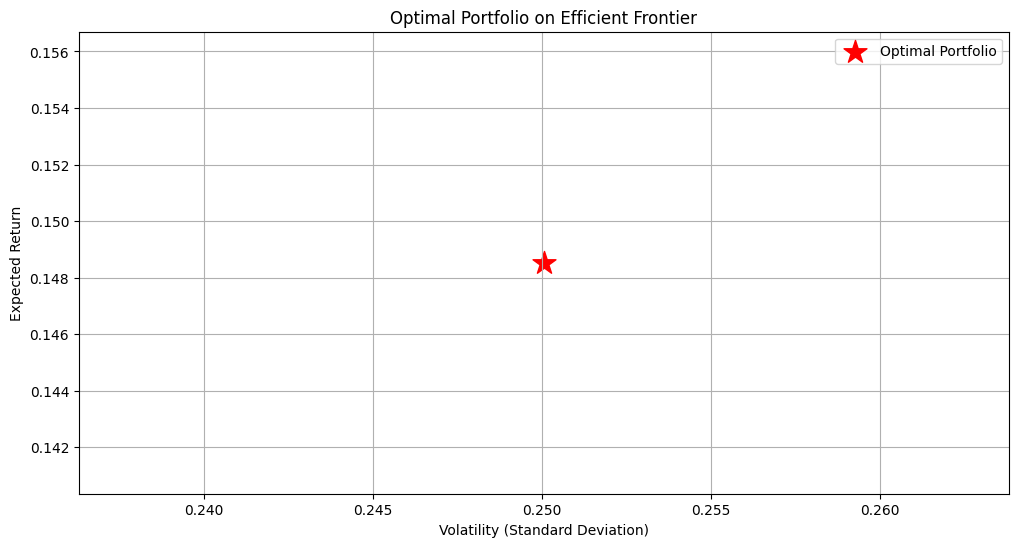

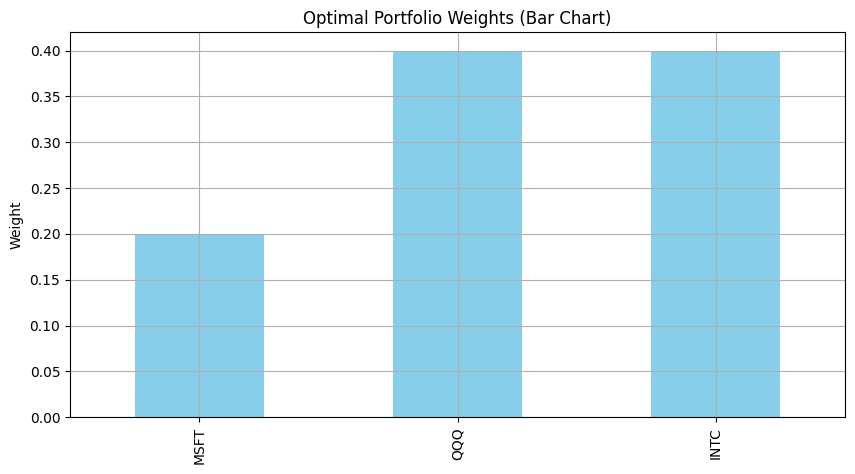

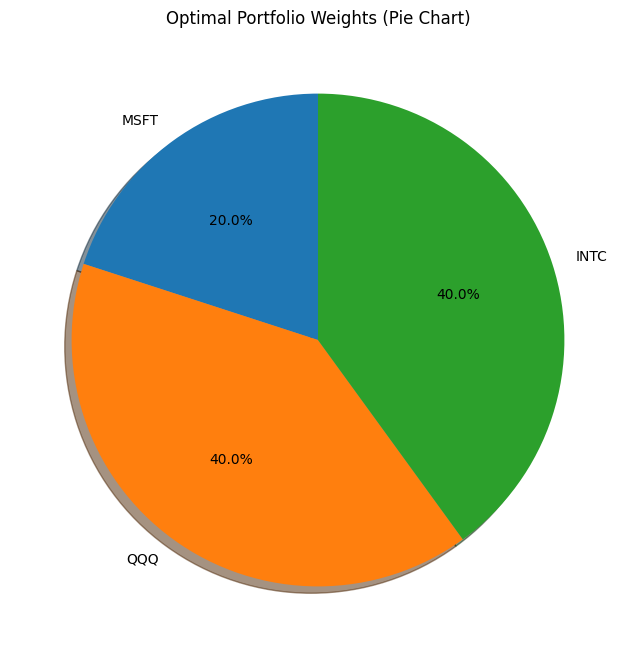

In [2]:


# Step 8: Display results
results = pd.Series(optimal_weights, index=stocks)
results["Expected Return"] = optimal_return
results["Volatility"] = optimal_volatility
results["Sharpe Ratio"] = optimal_sharpe

# Visualization: Efficient Frontier (just the optimal point here)
plt.figure(figsize=(12, 6))
plt.title("Optimal Portfolio on Efficient Frontier")
plt.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=300, label='Optimal Portfolio')
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.legend()
plt.show()

# Bar Chart of Portfolio Weights
plt.figure(figsize=(10, 5))
plt.title("Optimal Portfolio Weights (Bar Chart)")
results[:-3].plot(kind='bar', color='skyblue')
plt.ylabel("Weight")
plt.grid(True)
plt.savefig("opt_port1.png", dpi=300)
plt.show()

# Pie Chart of Portfolio Weights
plt.figure(figsize=(8, 8))
plt.title("Optimal Portfolio Weights (Pie Chart)")
results[:-3].plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=True)
plt.ylabel("")  # Hide y-label
plt.savefig("opt_port2.png", dpi=300)
plt.show()
